#HW 6

In [1]:
# Загрузка библиотек

import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np

In [2]:
# Параметры

max_words = 2000
max_len = 10
num_classes = 1

# Training

epochs = 25
batch_size = 512
print_batch_n = 100

In [3]:
# Загрузка данных

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
train_csv = '/content/drive/My Drive/Twitter Sentiment Analysis/train.csv'
test_csv = '/content/drive/My Drive/Twitter Sentiment Analysis/test.csv'

---

In [12]:
# Создание df

df = pd.read_csv(train_csv)

df_train , df_val = df[:25000].copy(), df[25001:].copy()

df_test = pd.read_csv(test_csv)

In [13]:
df_train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [14]:
df_train['label'].value_counts()

0    23246
1     1754
Name: label, dtype: int64

In [15]:
df_val['label'].value_counts()

0    6473
1     488
Name: label, dtype: int64

In [16]:
# Установка pymorphy2

!pip install stop-words pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 3.3 MB/s 
     |████████████████████████████████| 8.2 MB 8.1 MB/s 
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32911 sha256=4052d8d9e602f2328fbe1e056f3f1529d9293517ff37bbadda8fc79b83d239be
  Stored in directory: /root/.cache/pip/wheels/fb/86/b2/277b10b1ce9f73ce15059bf6975d4547cc4ec3feeb651978e9
Successfully built stop-words


In [17]:
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re

In [18]:
sw = set(get_stop_words("en"))
sw

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 "can't",
 'cannot',
 'could',
 "couldn't",
 'did',
 "didn't",
 'do',
 'does',
 "doesn't",
 'doing',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 "hadn't",
 'has',
 "hasn't",
 'have',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'her',
 'here',
 "here's",
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 "how's",
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 "let's",
 'me',
 'more',
 'most',
 "mustn't",
 'my',
 'myself',
 'no',
 'nor',
 'not',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'ought',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'same',
 "shan't",
 'she',
 "she'd",
 "she'll",
 "she's",
 'should',
 "s

In [19]:
puncts = set(punctuation)
puncts

{'!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~'}

In [20]:
# Morpher

morpher = MorphAnalyzer()

In [21]:
# Define preprocess

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in puncts)
    txt = txt.lower()
    txt = re.sub("не\s", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

In [22]:
df_train['tweet'].iloc[:1].values

array([' @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run'],
      dtype=object)

In [23]:
df_train['tweet'].iloc[:1].apply(preprocess_text).values

array(['user father dysfunctional selfish drags kids dysfunction run'],
      dtype=object)

In [24]:
from tqdm import tqdm 
tqdm.pandas()

df_train['tweet'] = df_train['tweet'].progress_apply(preprocess_text)
df_val['tweet'] = df_val['tweet'].progress_apply(preprocess_text)

100%|██████████| 6961/6961 [00:02<00:00, 2609.48it/s]


In [25]:
train_corpus = " ".join(df_train["tweet"])
train_corpus = train_corpus.lower()

In [26]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download("punkt")

tokens = word_tokenize(train_corpus)
tokens[:5]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


['user', 'father', 'dysfunctional', 'selfish', 'drags']

In [27]:
# Частые токены

tokens_filtered = [word for word in tokens if word.isalnum()]

In [28]:
from nltk.probability import FreqDist

dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]  # вычитание 1 для padding
len(tokens_filtered_top)

1999

In [29]:
tokens_filtered_top[:10]

['user', 'love', 'day', 'happy', 'amp', 'just', 'will', 'u', 'im', 'time']

In [30]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}
vocabulary

{'user': 1,
 'love': 2,
 'day': 3,
 'happy': 4,
 'amp': 5,
 'just': 6,
 'will': 7,
 'u': 8,
 'im': 9,
 'time': 10,
 'life': 11,
 'like': 12,
 'today': 13,
 'new': 14,
 'now': 15,
 'positive': 16,
 'get': 17,
 'thankful': 18,
 'people': 19,
 'bihday': 20,
 'cant': 21,
 'good': 22,
 'see': 23,
 'one': 24,
 'can': 25,
 'dont': 26,
 'fathers': 27,
 'smile': 28,
 'go': 29,
 'want': 30,
 'work': 31,
 'take': 32,
 'healthy': 33,
 'weekend': 34,
 'got': 35,
 'fun': 36,
 'make': 37,
 'summer': 38,
 '2': 39,
 'going': 40,
 'bull': 41,
 'friday': 42,
 'beautiful': 43,
 'way': 44,
 'best': 45,
 'family': 46,
 'us': 47,
 'need': 48,
 'great': 49,
 'first': 50,
 'days': 51,
 'friends': 52,
 'wait': 53,
 'really': 54,
 'music': 55,
 'back': 56,
 'know': 57,
 'world': 58,
 'tomorrow': 59,
 'morning': 60,
 'fathersday': 61,
 'sad': 62,
 'never': 63,
 'think': 64,
 'orlando': 65,
 'week': 66,
 'feel': 67,
 'cute': 68,
 'blog': 69,
 'right': 70,
 'affirmation': 71,
 'much': 72,
 'trump': 73,
 'happiness'

In [31]:
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])

    padding = [0] * (maxlen-len(result))
    return result[-maxlen:] + padding

In [32]:
%%time
x_train = np.asarray([text_to_sequence(text, max_len) for text in df_train["tweet"]])
x_val = np.asarray([text_to_sequence(text, max_len) for text in df_val["tweet"]])

CPU times: user 4.84 s, sys: 10.1 ms, total: 4.85 s
Wall time: 5.36 s


In [33]:
x_train.shape

(25000, 10)

In [34]:
df_train['tweet'].iloc[0]

'user father dysfunctional selfish drags kids dysfunction run'

In [35]:
x_train[0]

array([  1, 170, 164, 374,   0,   0,   0,   0,   0,   0])

In [36]:
# Class Net

class Net(nn.Module):
    def __init__(self, vocab_size=2000, embedding_dim=128, out_channel=128, num_classes=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv_1 = nn.Conv1d(embedding_dim, out_channel, kernel_size=2)
        self.conv_2 = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.pool = nn.MaxPool1d(2)
        self.relu = nn.ReLU()
        self.linear_1 = nn.Linear(out_channel, out_channel // 2)
        self.linear_2 = nn.Linear(out_channel // 2, num_classes)
        
    def forward(self, x):        
        output = self.embedding(x) # B, L, E
        #                       B  E  L         
        output = output.permute(0, 2, 1)
        output = self.conv_1(output)
        output = self.relu(output)
        output = self.pool(output)

        output = self.conv_2(output)
        output = self.relu(output)
        output = self.pool(output)
        output = torch.max(output, axis=2).values
        output = self.linear_1(output)
        output = self.relu(output)
        output = self.linear_2(output)
        output = F.sigmoid(output)
        return output

In [37]:
from torch.utils.data import DataLoader, Dataset


class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [38]:
train_dataset = DataWrapper(x_train, df_train['label'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DataWrapper(x_val, df_val['label'].values)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

In [39]:
for x, l in train_loader:
    print(x.shape)
    print(l.shape)
    print(l[0])
    break

torch.Size([512, 10])
torch.Size([512])
tensor(0)


In [40]:
model = Net(vocab_size=max_words)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [41]:
# Вывод

print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

Net(
  (embedding): Embedding(2000, 128)
  (conv_1): Conv1d(128, 128, kernel_size=(2,), stride=(1,))
  (conv_2): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (linear_1): Linear(in_features=128, out_features=64, bias=True)
  (linear_2): Linear(in_features=64, out_features=1, bias=True)
)
Parameters: 346497


In [42]:
# Optimizer, criterion

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss()

In [43]:
# Model

model = model.to(device)
model.train()
th = 0.4

train_loss_history = []
test_loss_history = []


for epoch in range(epochs):  
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # обнуляем градиент
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        
    # выводим статистику о процессе обучения
    model.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_loader)}]. ' \
            f'Loss: {loss:.3f}. ' \
            f'Acc: {running_right / running_items:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history.append(loss)

        # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(val_loader):
        test_labels = data[1].to(device)
        test_outputs = model(data[0].to(device))
        
        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()
    
    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')
    
    model.train()
        
print('Training is finished!')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch [1/25]. Step [49/49]. Loss: 0.165. Acc: 0.916. Test loss: 0.013. Test acc: 0.937
Epoch [2/25]. Step [49/49]. Loss: 0.098. Acc: 0.947. Test loss: 0.015. Test acc: 0.945
Epoch [3/25]. Step [49/49]. Loss: 0.148. Acc: 0.963. Test loss: 0.001. Test acc: 0.945
Epoch [4/25]. Step [49/49]. Loss: 0.094. Acc: 0.973. Test loss: 0.000. Test acc: 0.943
Epoch [5/25]. Step [49/49]. Loss: 0.059. Acc: 0.982. Test loss: 0.001. Test acc: 0.937
Epoch [6/25]. Step [49/49]. Loss: 0.030. Acc: 0.985. Test loss: 0.000. Test acc: 0.933
Epoch [7/25]. Step [49/49]. Loss: 0.034. Acc: 0.990. Test loss: 0.000. Test acc: 0.942
Epoch [8/25]. Step [49/49]. Loss: 0.030. Acc: 0.992. Test loss: 0.000. Test acc: 0.942
Epoch [9/25]. Step [49/49]. Loss: 0.060. Acc: 0.993. Test loss: 0.000. Test acc: 0.940
Epoch [10/25]. Step [49/49]. Loss: 0.013. Acc: 0.995. Test loss: 0.000. Test acc: 0.945
Epoch [11/25]. Step [49/49]. Loss: 0.007. Acc: 0.995. Test loss: 0.000. Test acc: 0.944
Epoch [12/25]. Step [49/49]. Loss: 0.020.

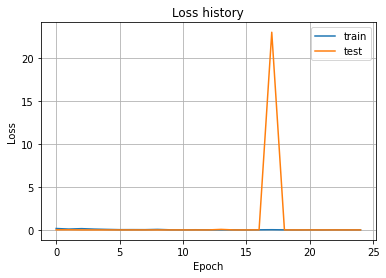

In [44]:
# Plot

import matplotlib.pyplot as plt

plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.legend();